# Семинар 9
## Практикум по ML

На сегодняшнем семинаре мы будем решать задачу машинного обучения с самого начала до самого конца.

Мы вспомним все подходы, которые мы прошли и познакомимся с новыми библиотеками и финтами. Также мы обсудим постаноки задач и то, как можно по-разному смотреть на одни и те же данные в зависимости от поставленных целей.

Мы воспользуемся данными из соревнования [European Soccer Database](https://www.kaggle.com/datasets/hugomathien/soccer) в которых представлена информация о игроках, командах и матчах футбольной лиги.

Мы поставим себе две задачи:

1. Предсказать сколько очков наберет команда в предстоящей игре. *(Какая это задача?)*
2. Предсказать исход предстоящих игр команду -- победа первой команды, ничья, победа второй команды. *(А какая это задача?)*

В ресурсах соревнования данные хранятся в формате `*.sqlite` -- это файл базы данных `SQLite`, основанной на `CSV`. Мы научимся работать с таким форматом данных.

Поскольку мы имеем просто необработанные данные, на нас ложится ответственность по созданию датасета с признаками и таргет. *(в большинстве своем это начало работы обычного data scientist-а)*

Тогда нашу работу можно разделить на следующие этапы:
1. Собрать датасет с признаками из базы данных;
2. Разбить данные на обучение и тест;
3. Провести первичный анализ данных;
4. Задача регрессии:
    - Построить baseline модель;
    - Провести отбор признаков;
    - Обучить основную модель;
5. Задача классификации:
    - Провести балансировку классов или соединить/выкинуть один из классов (если требуется);
    - Построить baseline модель;
    - Провести отбор признаков;
    - Обучить основную модель;
6. Написать отчет по проделанной работе.

## Загрузка и осмотр данных

### Скачаем и разархивируем данные

In [ ]:
# Если вы работаете на локальном компьютере и не имеете unzip, gdown или sqlite
! pip install -U --no-cache-dir gdown --pre
# ! sudo apt-get install unzip
# ! pip install db-sqlite3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import pandas as pd
import sqlite3

# Уберем ограничения на число столбцов, которые будет выводить pandas, чтобы было удобнее анализировать данные
pd.set_option('display.max_columns', None)

In [ ]:
# Скачаем архив с данными при помощи команды gdown (второй аргумент -- это не ссылка на файл!)
# file_id = 15ARavbyB2AIhq4l7Y4CcxH2S7CX35jdm
! gdown https://drive.google.com/uc?id=15ARavbyB2AIhq4l7Y4CcxH2S7CX35jdm

Downloading...
From: https://drive.google.com/uc?id=15ARavbyB2AIhq4l7Y4CcxH2S7CX35jdm
To: /content/EuropeanSoccerDatabase.zip
100% 34.3M/34.3M [00:01<00:00, 30.0MB/s]


In [ ]:
# Разархивируем данные в папку Datasets
! unzip EuropeanSoccerDatabase.zip -d Datasets

Archive:  EuropeanSoccerDatabase.zip
  inflating: Datasets/database.sqlite  


In [ ]:
# Проверим, что все получилось -- тут должен быть файл database.sqlite
! ls Datasets/

database.sqlite


### Проанализируем какие данные у нас есть

In [ ]:
# Подсоединимся к базе данных

db_connect = sqlite3.connect('Datasets/database.sqlite')

In [ ]:
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql_query(sql_query, db_connect)

,name
0,sqlite_sequence
1,Player_Attributes
2,Player
3,Match
4,League
5,Country
6,Team
7,Team_Attributes


In [ ]:
# Таблица Country. Что представляют из себя данные?

country = pd.read_sql_query("SELECT * FROM Country", db_connect)
country.head(5)

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [ ]:
# Файл League. Что представляют из себя данные?

league = pd.read_sql_query("SELECT * FROM League", db_connect)
league.head(5)

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [ ]:
# Файл Match. Что представляют из себя данные?

match = pd.read_sql_query("SELECT * FROM Match", db_connect)
match.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [ ]:
# Посмотрим на размер этой таблицы

match.shape

(25979, 115)

Видим, что поля связанные с игроками пустые. К сожалению авторами были удалены данные о том, какие игроки в составе каких команд играли в матчах. Иначе можно было бы поставить еще интересные задачи -- например сколько очков наберет футболист в предстоящем матче и в какой лиге:)

Кроме того, не все данные мы бы хотели использовать. Например последние столбцы являются ставкой в разных букмекерских конторах (например WHA/WHD/WHH - это William Hill Away/William Hill Draw/William Hill Home, то есть ставка у букмекера William Hill на победу гостей/etc.).

Если вы захотите зарабатывать на ставках, то коэффициенты будут точно полезны, ну а мы не станем их использовать и возьмем только первые 11 столбцов:)


['id', 'country_id', 'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']

In [ ]:
# Файл Player. Что представляют из себя данные?

player = pd.read_sql_query("SELECT * FROM Player", db_connect)
player.head(5)

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [ ]:
# Файл Player_Attributes. Что представляют из себя данные?

player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", db_connect)
player_attributes.head(5)

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [ ]:
# Файл Team. Что представляют из себя данные?

team = pd.read_sql_query("SELECT * FROM Team", db_connect)
team.head(5)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [ ]:
# Файл Team_Attributes. Что представляют из себя данные?

team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", db_connect)
team_attributes.head(5)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


## Создание датасета

Первое, что нам нужно понять, это то, какие признаки мы бы хотели создать для нашей задачи. Приведем несколько тех, которые нам кажутся разумными, но мы можем придумать с вами еще и другие. Это будет очень полезно!

Второе, что хочется отметить -- формат того, как мы будем собирать датасет зависит от нас, но мы предлагаем сделать следующее -- датасет будет состоять из соединенных признаков двух команд, которые играют в матче. То есть число объектов -- число сыгранных матчей.

Нам важно построить признаки так, чтобы мы не заглядывали в будущее, поэтому предлагается сделать следующее -- для каждой лиги и команды в тестовую часть добавить все последние игры. (то есть для каждой команды в тестовой выборке будет максимум 11 строк)

Нам важно запомнить даты матча, чтобы собирать признаки до этой даты.

### Признаки связанные с лигами:

1. Сколько очков команда забила в каждой из лиг:
    - В этом сезоне;
    - В прошлом сезоне;
    - За все время.
2. Максимальное/среднее число очков, которое команда забила в каждой из лиг:
    - В этом сезоне;
    - В прошлом сезоне;
    - За все сезоне.
3. Общее количество и доля побед, которые одержала команда в каждой из лиг:
    - В этом году;
    - В прошлом году;
    - За все сезоне.
4. Была ли прошлая игра в каждой из лиг победной и сколько очков команда набрала.

Это уже $11\cdot 3 + 2 \cdot 11 \cdot 3 + 2 \cdot 11 \cdot 3 + 2 = 167$!

А это только первая группа признаков... Давайте сократим список до минимального набора, чтобы хотя бы уместиться в лимиты памяти)

Вот, мы уже себя ограничиваем, хотя только начали генерацию фичей:( Но ничего не поделаешь!

1. Среднее число очков, которое команда забила в лиге, в которой предстоит игра:
    - В этом сезоне;
    - В прошлом сезоне.
2. Доля побед, которые одержала команда в лиге, в которой предстоит игра:
    - В этом сезоне;
    - В прошлом сезоне.
3. Была ли прошлая игра в текущей лиге и текущем сезоне победной и сколько очков команда набрала.

Итого будет $2 + 2 + 2 = 6$.

Но напомню, что мы можем попытаться реализовать и ваши идеи. Дерзайте! Сейчас самое время предложить свою идею:)

In [ ]:
# Будем делать глубокую копию датасета, чтобы не поменять исходный датасет
from copy import deepcopy

import numpy as np

In [ ]:
# Информацию об играх в сезонах мы можем получить из таблицы match
# Первым делом создадим датасет, из которого удалены все ненужные нам столбцы.

important_match_feat = ['id', 'country_id', 'league_id', 'season', 'stage',
'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id',
'home_team_goal', 'away_team_goal']

df = match[important_match_feat]

In [ ]:
# Посмотрим случайную подвыборку получившегося датасета

df.sample(10)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
10659,10660,10257,10257,2009/2010,11,2009-10-31 00:00:00,704544,9885,9875,2,3
6025,6026,4769,4769,2011/2012,2,2011-08-13 00:00:00,1019353,9874,7819,1,2
19958,19959,19694,19694,2009/2010,15,2009-12-12 00:00:00,658884,9800,8596,1,1
18962,18963,17642,17642,2013/2014,23,2014-03-16 00:00:00,1498189,158085,2033,2,0
12104,12105,10257,10257,2012/2013,7,2012-10-07 00:00:00,1287027,8530,10167,2,0
18068,18069,17642,17642,2009/2010,30,2010-05-09 00:00:00,686333,6403,2033,2,2
18977,18978,17642,17642,2013/2014,25,2014-03-30 00:00:00,1498208,10215,2033,2,1
23175,23176,21518,21518,2012/2013,21,2013-01-27 00:00:00,1260005,8633,8305,4,0
25058,25059,24558,24558,2010/2011,35,2011-05-22 00:00:00,954547,10199,10243,0,5
1337,1338,1,1,2014/2015,2,2014-08-02 00:00:00,1717826,9987,9984,1,1


Создадим два вспомогательных датасета, которые потом совместим в один.

In [ ]:
## Первый будет содержать информацию об домашне команде (id команды запишем в колонку TEAM_ID), число забитых и факт победы или поражения

# Создадим пустой pandas датасет
HOME_TEAM_DF = pd.DataFrame()

# Добавим в HOME_TEAM_DF столбец TEAM_ID с значениями home_team_api_id
HOME_TEAM_DF['TEAM_ID'] = deepcopy(match['home_team_api_id'])

# league_id, season, stage, date, match_api_id переносим без изменений
HOME_TEAM_DF[['league_id', 'season', 'stage', 'date', 'match_api_id']] = \
    deepcopy(match[['league_id', 'season', 'stage', 'date', 'match_api_id']])

# Добавим число забитых голов home_team_goal в колонку GOALS
HOME_TEAM_DF['GOALS'] = deepcopy(match['home_team_goal'])

# Добавим поле RESULT, которое будет содержать результат матча: -1 -- проигрыш, 0 -- ничья, 1 -- выигрыш
# Можем это сделать либо при помощи функции apply, либо при помощи булевых преобразований столбцов
HOME_TEAM_DF['RESULT'] = match['home_team_goal'] - match['away_team_goal']
HOME_TEAM_DF['RESULT'] = HOME_TEAM_DF['RESULT'].apply(np.sign)

# Добавим поле IS_HOME, которая говорит проводилась ли игра на домашнем поле. Тут оно везде равно 1
HOME_TEAM_DF['IS_HOME'] = 1

In [ ]:
# Посмотрим что получилось
HOME_TEAM_DF

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME
0,9987,1,2008/2009,1,2008-08-17 00:00:00,492473,1,0,1
1,10000,1,2008/2009,1,2008-08-16 00:00:00,492474,0,0,1
2,9984,1,2008/2009,1,2008-08-16 00:00:00,492475,0,-1,1
3,9991,1,2008/2009,1,2008-08-17 00:00:00,492476,5,1,1
4,7947,1,2008/2009,1,2008-08-16 00:00:00,492477,1,-1,1
...,...,...,...,...,...,...,...,...,...
25974,10190,24558,2015/2016,9,2015-09-22 00:00:00,1992091,1,1,1
25975,9824,24558,2015/2016,9,2015-09-23 00:00:00,1992092,1,-1,1
25976,9956,24558,2015/2016,9,2015-09-23 00:00:00,1992093,2,1,1
25977,7896,24558,2015/2016,9,2015-09-22 00:00:00,1992094,0,0,1


In [ ]:
## Второй будет содержать тоже самое, но о гостевой команде

# Создадим пустой pandas датасет
AWAY_TEAM_DF = pd.DataFrame()

# Добавим в AWAY_TEAM_DF столбец TEAM_ID с значениями away_team_api_id
AWAY_TEAM_DF['TEAM_ID'] = deepcopy(match['away_team_api_id'])

# league_id, season, stage, date, match_api_id переносим без изменений
AWAY_TEAM_DF[['league_id', 'season', 'stage', 'date', 'match_api_id']] = \
    deepcopy(match[['league_id', 'season', 'stage', 'date', 'match_api_id']])

# Добавим число забитых голов away_team_goal в колонку GOALS
AWAY_TEAM_DF['GOALS'] = deepcopy(match['away_team_goal'])

# Добавим поле RESULT, которое будет содержать результат матча: -1 -- проигрыш, 0 -- ничья, 1 -- выигрыш
# Можем это сделать либо при помощи функции apply, либо при помощи булевых преобразований столбцов
AWAY_TEAM_DF['RESULT'] = match['away_team_goal'] - match['home_team_goal']
AWAY_TEAM_DF['RESULT'] = AWAY_TEAM_DF['RESULT'].apply(np.sign)

# Добавим поле IS_HOME, которая говорит проводилась ли игра на домашнем поле. Тут оно везде равно 0
AWAY_TEAM_DF['IS_HOME'] = 0

In [ ]:
# Посмотрим что получилось
AWAY_TEAM_DF.head()

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME
0,9993,1,2008/2009,1,2008-08-17 00:00:00,492473,1,0,0
1,9994,1,2008/2009,1,2008-08-16 00:00:00,492474,0,0,0
2,8635,1,2008/2009,1,2008-08-16 00:00:00,492475,3,1,0
3,9998,1,2008/2009,1,2008-08-17 00:00:00,492476,0,-1,0
4,9985,1,2008/2009,1,2008-08-16 00:00:00,492477,3,1,0


In [ ]:
# Соединим два датасета в один при помощи pd.concat создав глубокую копию, а временные таблицы удалим при помощи del
TEAM_DF = deepcopy(pd.concat([HOME_TEAM_DF, AWAY_TEAM_DF]))
del HOME_TEAM_DF
del AWAY_TEAM_DF

In [ ]:
# Посмотрим, что получилось
TEAM_DF

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME
0,9987,1,2008/2009,1,2008-08-17 00:00:00,492473,1,0,1
1,10000,1,2008/2009,1,2008-08-16 00:00:00,492474,0,0,1
2,9984,1,2008/2009,1,2008-08-16 00:00:00,492475,0,-1,1
3,9991,1,2008/2009,1,2008-08-17 00:00:00,492476,5,1,1
4,7947,1,2008/2009,1,2008-08-16 00:00:00,492477,1,-1,1
...,...,...,...,...,...,...,...,...,...
25974,10191,24558,2015/2016,9,2015-09-22 00:00:00,1992091,0,-1,0
25975,10199,24558,2015/2016,9,2015-09-23 00:00:00,1992092,2,1,0
25976,10179,24558,2015/2016,9,2015-09-23 00:00:00,1992093,0,-1,0
25977,10243,24558,2015/2016,9,2015-09-22 00:00:00,1992094,0,0,0


Отлично, начальная подготовка выполнена, теперь перейдем к созданию фичей.

Часто мы будем пребегать к неоптимальным практикам, которые позволяют писать код быстрее. Всегда, когда у вас достаточно времени на выполнение задачи, стоит задумываться об оптимальности решения -- вы потратите больше времени сейчас, но зато в будущем сэкономите гораздо больше.

In [ ]:
# Для того, чтобы посчитать число забитых голов за определенный сезон в определенной лиге
# Мы можем воспользоваться кумулятивной суммой (pd.Series.cumsum) в transform,
# сгруппировав при этом данные по id команды, лиги и сезону и отсортировав по дате
# Что такое кумулятивная сумма?

# pandas в отличии от sql или spark гарантирует сохранение последовательности строк, поэтому мы можем пропустить многие преобразования
TEAM_DF = TEAM_DF.sort_values(['TEAM_ID', 'league_id', 'date'])

# Создадим колонку GOAL_PREV_MATCH_SEASON в которой будет хранится число забитых голов команы в конкретной лиге !!С текущей игрой!!
TEAM_DF["GOAL_PREV_MATCH_SEASON"] = TEAM_DF.groupby(['TEAM_ID', 'league_id', 'season'])['GOALS'].transform(pd.Series.cumsum)

# Для того, чтобы избавиться от заглядывания в текущее число голов -- вычтим GOALS из GOAL_PREV_MATCH_SEASON
TEAM_DF["GOAL_PREV_MATCH_SEASON"] = TEAM_DF["GOAL_PREV_MATCH_SEASON"] - TEAM_DF["GOALS"]

# Посмотрим, что получилось
TEAM_DF

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME,GOAL_PREV_MATCH_SEASON
15722,1601,15722,2008/2009,1,2008-08-10 00:00:00,506542,0,0,0,0
15809,1601,15722,2008/2009,2,2008-08-16 00:00:00,506549,2,1,1,0
15897,1601,15722,2008/2009,3,2008-08-22 00:00:00,506557,2,1,1,2
15915,1601,15722,2008/2009,4,2008-08-30 00:00:00,506567,0,-1,0,4
15921,1601,15722,2008/2009,5,2008-09-12 00:00:00,506573,2,1,1,4
...,...,...,...,...,...,...,...,...,...,...
1633,274581,1,2015/2016,26,2016-02-12 00:00:00,1980025,0,-1,0,32
1644,274581,1,2015/2016,27,2016-02-20 00:00:00,1980036,3,1,1,32
1654,274581,1,2015/2016,28,2016-02-27 00:00:00,1980046,2,0,0,35
1660,274581,1,2015/2016,29,2016-03-05 00:00:00,1980052,2,1,1,37


In [ ]:
# Теперь нам нужно посчитать сколько голов забила команда в прошлом сезоне конкретной лиги.
# Эта задача еще проще -- нам нужно сгруппировать данные команды по лиге и по сезону и просто найти сумму в них.
# После этого нужно присоединить такую табличку к TEAM_DF по season

# Создадим табличку GOAL_PER_LS сгруппировав по команде, лиге, сезону и найдя сумму колонки GOALS
GOAL_PER_LS = TEAM_DF.groupby(['TEAM_ID', 'league_id', 'season'])[['GOALS']].sum()

# Посмотрим, что вышло
GOAL_PER_LS

GOALS
TEAM_ID league_id season          
1601    15722     2008/2009     22
                  2009/2010     40
                  2010/2011     29
                  2011/2012     44
                  2012/2013     35
...                            ...
177361  15722     2015/2016     33
188163  17642     2015/2016     34
208931  10257     2015/2016     37
274581  1         2014/2015     32
                  2015/2016     39

[1481 rows x 1 columns]

In [ ]:
# Что получить голы с прошлого сезона, нам нужно сместить все данные одной команды в одной лиге сместить на 1 вниз.
# С этим нам может помочь метод shift, который смещает все данные на то число строк, которое указано у него в аргументе

# Сгруппируем датасет по команде и лиги и сделаем shift и присоединим этот столбец к GOAL_PER_LS, назвав GOALS_PREV_SEASON
# И посмотрим, что из этого вышло
GOAL_PER_LS['GOALS_PREV_SEASON'] = GOAL_PER_LS.groupby(['TEAM_ID', 'league_id']).shift(1)['GOALS']
GOAL_PER_LS

GOALS  GOALS_PREV_SEASON
TEAM_ID league_id season                             
1601    15722     2008/2009     22                NaN
                  2009/2010     40               22.0
                  2010/2011     29               40.0
                  2011/2012     44               29.0
                  2012/2013     35               44.0
...                            ...                ...
177361  15722     2015/2016     33                NaN
188163  17642     2015/2016     34                NaN
208931  10257     2015/2016     37                NaN
274581  1         2014/2015     32                NaN
                  2015/2016     39               32.0

[1481 rows x 2 columns]

In [ ]:
# Сделаем reset_index, чтобы переместить TEAM_ID, league_id, season в столбцы
# А также удалим GOALS
GOAL_PER_LS = GOAL_PER_LS.reset_index().drop(columns="GOALS")
GOAL_PER_LS

,TEAM_ID,league_id,season,GOALS_PREV_SEASON
0,1601,15722,2008/2009,NaN
1,1601,15722,2009/2010,22.0
2,1601,15722,2010/2011,40.0
3,1601,15722,2011/2012,29.0
4,1601,15722,2012/2013,44.0
...,...,...,...,...
1476,177361,15722,2015/2016,NaN
1477,188163,17642,2015/2016,NaN
1478,208931,10257,2015/2016,NaN
1479,274581,1,2014/2015,NaN


In [ ]:
# Приджоиним (.merge()) GOAL_PER_LS к TEAM_DF по (on) TEAM_ID, league_id и season с типом соединения (how) left
# Почему мы используем left?

TEAM_DF = TEAM_DF.merge(GOAL_PER_LS, on=['TEAM_ID', 'league_id', 'season'], how='left')
TEAM_DF

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON
0,1601,15722,2008/2009,1,2008-08-10 00:00:00,506542,0,0,0,0,NaN
1,1601,15722,2008/2009,2,2008-08-16 00:00:00,506549,2,1,1,0,NaN
2,1601,15722,2008/2009,3,2008-08-22 00:00:00,506557,2,1,1,2,NaN
3,1601,15722,2008/2009,4,2008-08-30 00:00:00,506567,0,-1,0,4,NaN
4,1601,15722,2008/2009,5,2008-09-12 00:00:00,506573,2,1,1,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...
51953,274581,1,2015/2016,26,2016-02-12 00:00:00,1980025,0,-1,0,32,32.0
51954,274581,1,2015/2016,27,2016-02-20 00:00:00,1980036,3,1,1,32,32.0
51955,274581,1,2015/2016,28,2016-02-27 00:00:00,1980046,2,0,0,35,32.0
51956,274581,1,2015/2016,29,2016-03-05 00:00:00,1980052,2,1,1,37,32.0


Ура, мы подготовили все, что нужно для первого пункта! Останется только развернуть датасет, но это будет позже.

Сейчас мы начнем подготавливать все ко второму пункту. Идейно мы будем делать все тоже самое, но будем работать с полем RESULT

In [ ]:
# Считать побед перед конкретной игрой можно следующим образом:
# - Заменяем минус 1 на 0
# - Считаем комулятивную сумму по RESULT
# - Создаем последовательность цифр в группе от 1 до |размер группы|
# - Делим один столбец на другой
# Почему описанный алгоритм пришедет к желаемому результату?

# Создадим поле IS_WINS, в котором будет стоять 1, если команда победила, иначе 0
TEAM_DF["IS_WINS"] = TEAM_DF["RESULT"] * (TEAM_DF["RESULT"] > 0)

In [ ]:
# Точно также как и с числом голов, отсортируем по команде, лиге, дате, затем сгруппируем по команде, лиге, сезону, возьмем колонку IS_WINS
# и посчитаем cumsum, которую запишем в колонку SUM_PREV_MATCH_SEASON
TEAM_DF = TEAM_DF.sort_values(['TEAM_ID', 'league_id', 'date'])

TEAM_DF["SUM_PREV_MATCH_SEASON"] = TEAM_DF.groupby(["TEAM_ID", "league_id", "season"])["IS_WINS"].transform(pd.Series.cumsum)

# Не забываем вычесть результат текущей игры!
TEAM_DF["SUM_PREV_MATCH_SEASON"] = TEAM_DF["SUM_PREV_MATCH_SEASON"] - TEAM_DF["IS_WINS"]

# Проделаем такую же сортировку и группировку, но примерним функцию .cumcount()
TEAM_DF["NUM_PREV_MATCH_SEASON"] = TEAM_DF.groupby(["TEAM_ID", "league_id", "season"])["IS_WINS"].cumcount()

# Поделив одно на другое, мы получим желаемый результат. Назовем его WIN_PROP_PREV_MATCH_SEASON
TEAM_DF["WINS_PROP_PREV_MATCH_SEASON"] = TEAM_DF["SUM_PREV_MATCH_SEASON"] / TEAM_DF["NUM_PREV_MATCH_SEASON"]

# Посмотрим на результат
TEAM_DF

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON,IS_WINS,SUM_PREV_MATCH_SEASON,NUM_PREV_MATCH_SEASON,WINS_PROP_PREV_MATCH_SEASON
0,1601,15722,2008/2009,1,2008-08-10 00:00:00,506542,0,0,0,0,NaN,0,0,0,NaN
1,1601,15722,2008/2009,2,2008-08-16 00:00:00,506549,2,1,1,0,NaN,1,0,1,0.000000
2,1601,15722,2008/2009,3,2008-08-22 00:00:00,506557,2,1,1,2,NaN,1,1,2,0.500000
3,1601,15722,2008/2009,4,2008-08-30 00:00:00,506567,0,-1,0,4,NaN,0,2,3,0.666667
4,1601,15722,2008/2009,5,2008-09-12 00:00:00,506573,2,1,1,4,NaN,1,2,4,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51953,274581,1,2015/2016,26,2016-02-12 00:00:00,1980025,0,-1,0,32,32.0,0,5,25,0.200000
51954,274581,1,2015/2016,27,2016-02-20 00:00:00,1980036,3,1,1,32,32.0,1,5,26,0.192308
51955,274581,1,2015/2016,28,2016-02-27 00:00:00,1980046,2,0,0,35,32.0,0,6,27,0.222222
51956,274581,1,2015/2016,29,2016-03-05 00:00:00,1980052,2,1,1,37,32.0,1,6,28,0.214286


In [ ]:
# Теперь нам нужно посчитать долю побед команды в прошлом сезоне каждой из лиг

# Сгруппируем датасет по команде, лиге и сезону и найдем долю побед и запишем это в таблицу PROP_WINS_PER_LS
PROP_WINS_PER_LS = TEAM_DF.groupby(['TEAM_ID', 'league_id', 'season'])[['IS_WINS']].sum() / \
                   TEAM_DF.groupby(['TEAM_ID', 'league_id', 'season'])[['IS_WINS']].count()

# Проделаем тот же финт с shift, что и раньше
PROP_WINS_PER_LS['WINS_PROP_PREV_SEASON'] = PROP_WINS_PER_LS.groupby(['TEAM_ID', 'league_id']).shift(1)['IS_WINS']

In [ ]:
# Сделаем reset_index, чтобы переместить TEAM_ID, league_id, season в столбцы
# А также удалим GOALS
PROP_WINS_PER_LS = PROP_WINS_PER_LS.reset_index().drop(columns="IS_WINS")
PROP_WINS_PER_LS

,TEAM_ID,league_id,season,WINS_PROP_PREV_SEASON
0,1601,15722,2008/2009,NaN
1,1601,15722,2009/2010,0.300000
2,1601,15722,2010/2011,0.533333
3,1601,15722,2011/2012,0.333333
4,1601,15722,2012/2013,0.533333
...,...,...,...,...
1476,177361,15722,2015/2016,NaN
1477,188163,17642,2015/2016,NaN
1478,208931,10257,2015/2016,NaN
1479,274581,1,2014/2015,NaN


In [ ]:
# Приджоиним (.merge()) PROP_WINS_PER_LS к TEAM_DF по (on) TEAM_ID, league_id и season с типом соединения (how) left
TEAM_DF = TEAM_DF.merge(PROP_WINS_PER_LS, on=['TEAM_ID', 'league_id', 'season'], how='left')
TEAM_DF

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON,IS_WINS,SUM_PREV_MATCH_SEASON,NUM_PREV_MATCH_SEASON,WINS_PROP_PREV_MATCH_SEASON,WINS_PROP_PREV_SEASON
0,1601,15722,2008/2009,1,2008-08-10 00:00:00,506542,0,0,0,0,NaN,0,0,0,NaN,NaN
1,1601,15722,2008/2009,2,2008-08-16 00:00:00,506549,2,1,1,0,NaN,1,0,1,0.000000,NaN
2,1601,15722,2008/2009,3,2008-08-22 00:00:00,506557,2,1,1,2,NaN,1,1,2,0.500000,NaN
3,1601,15722,2008/2009,4,2008-08-30 00:00:00,506567,0,-1,0,4,NaN,0,2,3,0.666667,NaN
4,1601,15722,2008/2009,5,2008-09-12 00:00:00,506573,2,1,1,4,NaN,1,2,4,0.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51953,274581,1,2015/2016,26,2016-02-12 00:00:00,1980025,0,-1,0,32,32.0,0,5,25,0.200000,0.233333
51954,274581,1,2015/2016,27,2016-02-20 00:00:00,1980036,3,1,1,32,32.0,1,5,26,0.192308,0.233333
51955,274581,1,2015/2016,28,2016-02-27 00:00:00,1980046,2,0,0,35,32.0,0,6,27,0.222222,0.233333
51956,274581,1,2015/2016,29,2016-03-05 00:00:00,1980052,2,1,1,37,32.0,1,6,28,0.214286,0.233333


In [ ]:
# И наконец последние две фичи -- их можно посчитать опять же при помощи функции shift

# Точно также как и с числом голов, отсортируем по команде, лиге, дате, затем сгруппируем по команде, лиге, сезону, возьмем колонку IS_WINS
# и посчитаем shift, которую запишем в колонку PREV_IS_WIN
TEAM_DF = TEAM_DF.sort_values(["TEAM_ID", "league_id", "date"])


TEAM_DF["PREV_IS_WIN"] = TEAM_DF.groupby(["TEAM_ID", "league_id", "season"])["IS_WINS"].shift(1)

# Аналогично с числом голов
TEAM_DF["PREV_GOALS"] = TEAM_DF.groupby(["TEAM_ID", "league_id", "season"])["GOALS"].shift(1)

# Посмотрим, что вышло
TEAM_DF

,TEAM_ID,league_id,season,stage,date,match_api_id,GOALS,RESULT,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON,IS_WINS,SUM_PREV_MATCH_SEASON,NUM_PREV_MATCH_SEASON,WINS_PROP_PREV_MATCH_SEASON,WINS_PROP_PREV_SEASON,PREV_IS_WIN,PREV_GOALS
0,1601,15722,2008/2009,1,2008-08-10 00:00:00,506542,0,0,0,0,NaN,0,0,0,NaN,NaN,NaN,NaN
1,1601,15722,2008/2009,2,2008-08-16 00:00:00,506549,2,1,1,0,NaN,1,0,1,0.000000,NaN,0.0,0.0
2,1601,15722,2008/2009,3,2008-08-22 00:00:00,506557,2,1,1,2,NaN,1,1,2,0.500000,NaN,1.0,2.0
3,1601,15722,2008/2009,4,2008-08-30 00:00:00,506567,0,-1,0,4,NaN,0,2,3,0.666667,NaN,1.0,2.0
4,1601,15722,2008/2009,5,2008-09-12 00:00:00,506573,2,1,1,4,NaN,1,2,4,0.500000,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51953,274581,1,2015/2016,26,2016-02-12 00:00:00,1980025,0,-1,0,32,32.0,0,5,25,0.200000,0.233333,0.0,0.0
51954,274581,1,2015/2016,27,2016-02-20 00:00:00,1980036,3,1,1,32,32.0,1,5,26,0.192308,0.233333,0.0,0.0
51955,274581,1,2015/2016,28,2016-02-27 00:00:00,1980046,2,0,0,35,32.0,0,6,27,0.222222,0.233333,1.0,3.0
51956,274581,1,2015/2016,29,2016-03-05 00:00:00,1980052,2,1,1,37,32.0,1,6,28,0.214286,0.233333,0.0,2.0


In [ ]:
# Удалим все ненужные столбцы и посмотрим, что осталось
TEAM_DF = TEAM_DF.drop(columns=["GOALS", "RESULT", "IS_WINS", "SUM_PREV_MATCH_SEASON", "NUM_PREV_MATCH_SEASON", "stage"])
TEAM_DF

,TEAM_ID,league_id,season,date,match_api_id,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON,WINS_PROP_PREV_MATCH_SEASON,WINS_PROP_PREV_SEASON,PREV_IS_WIN,PREV_GOALS
0,1601,15722,2008/2009,2008-08-10 00:00:00,506542,0,0,NaN,NaN,NaN,NaN,NaN
1,1601,15722,2008/2009,2008-08-16 00:00:00,506549,1,0,NaN,0.000000,NaN,0.0,0.0
2,1601,15722,2008/2009,2008-08-22 00:00:00,506557,1,2,NaN,0.500000,NaN,1.0,2.0
3,1601,15722,2008/2009,2008-08-30 00:00:00,506567,0,4,NaN,0.666667,NaN,1.0,2.0
4,1601,15722,2008/2009,2008-09-12 00:00:00,506573,1,4,NaN,0.500000,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
51953,274581,1,2015/2016,2016-02-12 00:00:00,1980025,0,32,32.0,0.200000,0.233333,0.0,0.0
51954,274581,1,2015/2016,2016-02-20 00:00:00,1980036,1,32,32.0,0.192308,0.233333,0.0,0.0
51955,274581,1,2015/2016,2016-02-27 00:00:00,1980046,0,35,32.0,0.222222,0.233333,1.0,3.0
51956,274581,1,2015/2016,2016-03-05 00:00:00,1980052,1,37,32.0,0.214286,0.233333,0.0,2.0


### Характеристики команд:

Здесь все просто -- мы будем использовать все характеристики команд, которые лежат в `team_attributes`. Надо только их предобработать:)

In [ ]:
# Посмотрим какие признаки у нас категориальные и как бы мы могли их конвертировать в числа (воспользуется info())
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

In [ ]:
# Заметим, что у всех признаков за исключением defenceDefenderLineClass, chanceCreationPositioningClass и buildUpPlayPositioningClass
# есть числовые аналоги, gоэтому предлагается избавиться от них, а с тройкой выше разобраться отдельно

team_attributes = team_attributes.drop(
    columns=[
        'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass', 'chanceCreationPassingClass',
        'chanceCreationCrossingClass', 'chanceCreationShootingClass',
        'defencePressureClass', 'defenceAggressionClass', 'defenceTeamWidthClass'
    ]
)

In [ ]:
# Посмотрим, что все верно
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,NaN,50,Organised,60,65,55,Organised,50,55,45,Cover
1,2,434,9930,2014-09-19 00:00:00,52,48.0,56,Organised,54,63,64,Organised,47,44,54,Cover
2,3,434,9930,2015-09-10 00:00:00,47,41.0,54,Organised,54,63,64,Organised,47,44,54,Cover
3,4,77,8485,2010-02-22 00:00:00,70,NaN,70,Organised,70,70,70,Organised,60,70,70,Cover
4,5,77,8485,2011-02-22 00:00:00,47,NaN,52,Organised,53,48,52,Organised,47,47,52,Cover


In [ ]:
# Посмотрим на уникальные значения оставшихся категориальных столбцов
print("buildUpPlayPositioningClass", team_attributes.buildUpPlayPositioningClass.unique())
print("chanceCreationPositioningClass", team_attributes.chanceCreationPositioningClass.unique())
print("defenceDefenderLineClass", team_attributes.defenceDefenderLineClass.unique())

buildUpPlayPositioningClass ['Organised' 'Free Form']
chanceCreationPositioningClass ['Organised' 'Free Form']
defenceDefenderLineClass ['Cover' 'Offside Trap']


In [ ]:
# Они просто бинарные! Так давайте и сделаем их бинарными при помощи функции replace
team_attributes.buildUpPlayPositioningClass = team_attributes.buildUpPlayPositioningClass.replace({"Organised": 1, "Free Form": 0})
team_attributes.chanceCreationPositioningClass = team_attributes.chanceCreationPositioningClass.replace({"Organised": 1, "Free Form": 0})
team_attributes.defenceDefenderLineClass = team_attributes.defenceDefenderLineClass.replace({"Cover": 1, "Offside Trap": 0})

In [ ]:
# Посмотрим, что у нас в итоге получилось
team_attributes

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,NaN,50,1,60,65,55,1,50,55,45,1
1,2,434,9930,2014-09-19 00:00:00,52,48.0,56,1,54,63,64,1,47,44,54,1
2,3,434,9930,2015-09-10 00:00:00,47,41.0,54,1,54,63,64,1,47,44,54,1
3,4,77,8485,2010-02-22 00:00:00,70,NaN,70,1,70,70,70,1,60,70,70,1
4,5,77,8485,2011-02-22 00:00:00,47,NaN,52,1,53,48,52,1,47,47,52,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,1454,15005,10000,2011-02-22 00:00:00,52,NaN,52,1,52,48,53,1,46,48,53,1
1454,1455,15005,10000,2012-02-22 00:00:00,54,NaN,51,1,47,52,50,1,44,55,53,1
1455,1456,15005,10000,2013-09-20 00:00:00,54,NaN,51,1,47,52,32,1,44,58,37,1
1456,1457,15005,10000,2014-09-19 00:00:00,54,42.0,51,1,47,52,32,1,44,58,37,1


In [ ]:
# Посмотрим на уникальные значения date. Что они значат?
team_attributes.date.unique()

array(['2010-02-22 00:00:00', '2014-09-19 00:00:00',
       '2015-09-10 00:00:00', '2011-02-22 00:00:00',
       '2012-02-22 00:00:00', '2013-09-20 00:00:00'], dtype=object)

In [ ]:
# Добавим столбец year_season полученный из date
team_attributes['year_season'] = pd.to_datetime(team_attributes.date).dt.year

In [ ]:
# А столбец с датой удалим, id и team_fifa_api_id удалим
team_attributes = team_attributes.drop(columns=['date', 'id', 'team_fifa_api_id'])

In [ ]:
# Для удобства дальнейшего join-а переименнуем team_api_id в TEAM_ID
team_attributes['TEAM_ID'] = team_attributes['team_api_id']
team_attributes = team_attributes.drop(columns=['team_api_id'])

In [ ]:
# Смотрим на итог
team_attributes

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass,year_season,TEAM_ID
0,60,NaN,50,1,60,65,55,1,50,55,45,1,2010,9930
1,52,48.0,56,1,54,63,64,1,47,44,54,1,2014,9930
2,47,41.0,54,1,54,63,64,1,47,44,54,1,2015,9930
3,70,NaN,70,1,70,70,70,1,60,70,70,1,2010,8485
4,47,NaN,52,1,53,48,52,1,47,47,52,1,2011,8485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,52,NaN,52,1,52,48,53,1,46,48,53,1,2011,10000
1454,54,NaN,51,1,47,52,50,1,44,55,53,1,2012,10000
1455,54,NaN,51,1,47,52,32,1,44,58,37,1,2013,10000
1456,54,42.0,51,1,47,52,32,1,44,58,37,1,2014,10000


### Собираем все вместе

In [ ]:
# Из датафрейма df удалим все ненужные столбцы -- этот датасет будем использовать как точку соединения всех признаков
df = df.drop(columns=["id", "country_id"])
df

,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3
3,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0
4,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3
...,...,...,...,...,...,...,...,...,...
25974,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,0
25975,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,2
25976,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,0
25977,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,0


In [ ]:
# Присоединим к TEAM_DF характеристики команд (по id команды и году).
# Нужно соединить их по годам. Вытащим год начала сезона из season

TEAM_DF['year_season'] = TEAM_DF['season'].str[:4].astype(int)

In [ ]:
# Присоединяем по году и TEAM_ID атрибуты команды к TEAM_DF
TEAM_DF = TEAM_DF.merge(team_attributes, on=['TEAM_ID', 'year_season'], how='left')

In [ ]:
# Проверим результат
TEAM_DF

,TEAM_ID,league_id,season,date,match_api_id,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON,WINS_PROP_PREV_MATCH_SEASON,WINS_PROP_PREV_SEASON,PREV_IS_WIN,PREV_GOALS,year_season,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
0,1601,15722,2008/2009,2008-08-10 00:00:00,506542,0,0,NaN,NaN,NaN,NaN,NaN,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1601,15722,2008/2009,2008-08-16 00:00:00,506549,1,0,NaN,0.000000,NaN,0.0,0.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1601,15722,2008/2009,2008-08-22 00:00:00,506557,1,2,NaN,0.500000,NaN,1.0,2.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1601,15722,2008/2009,2008-08-30 00:00:00,506567,0,4,NaN,0.666667,NaN,1.0,2.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1601,15722,2008/2009,2008-09-12 00:00:00,506573,1,4,NaN,0.500000,NaN,0.0,0.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51953,274581,1,2015/2016,2016-02-12 00:00:00,1980025,0,32,32.0,0.200000,0.233333,0.0,0.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0
51954,274581,1,2015/2016,2016-02-20 00:00:00,1980036,1,32,32.0,0.192308,0.233333,0.0,0.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0
51955,274581,1,2015/2016,2016-02-27 00:00:00,1980046,0,35,32.0,0.222222,0.233333,1.0,3.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0
51956,274581,1,2015/2016,2016-03-05 00:00:00,1980052,1,37,32.0,0.214286,0.233333,0.0,2.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0


In [ ]:
# Удалим столбцы с id лиги, сезоном и датой -- все это атрибуты матча, которые уже есть в таблице, к которой будем присоединять
TEAM_DF = TEAM_DF.drop(columns=['league_id', 'season', 'date'])

# Посмотрим, что имеем по итогу
TEAM_DF

,TEAM_ID,match_api_id,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON,WINS_PROP_PREV_MATCH_SEASON,WINS_PROP_PREV_SEASON,PREV_IS_WIN,PREV_GOALS,year_season,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
0,1601,506542,0,0,NaN,NaN,NaN,NaN,NaN,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1601,506549,1,0,NaN,0.000000,NaN,0.0,0.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1601,506557,1,2,NaN,0.500000,NaN,1.0,2.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1601,506567,0,4,NaN,0.666667,NaN,1.0,2.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1601,506573,1,4,NaN,0.500000,NaN,0.0,0.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51953,274581,1980025,0,32,32.0,0.200000,0.233333,0.0,0.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0
51954,274581,1980036,1,32,32.0,0.192308,0.233333,0.0,0.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0
51955,274581,1980046,0,35,32.0,0.222222,0.233333,1.0,3.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0
51956,274581,1980052,1,37,32.0,0.214286,0.233333,0.0,2.0,2015,50.0,50.0,50.0,1.0,50.0,50.0,50.0,1.0,45.0,45.0,50.0,1.0


In [ ]:
df

,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1
1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0
2,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3
3,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0
4,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3
...,...,...,...,...,...,...,...,...,...
25974,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,0
25975,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,2
25976,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,0
25977,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,0


In [ ]:
# Присоединим к df данные о домашней команде (TEAM_DF) по TEAM_ID и match_api_id
# Заметим, что поля отвечающие за названия команд отличаются, поэтмоу нам надо воспользоваться 
# Аргументами left_on, right_on вместо on
df = df.merge(TEAM_DF, how="left", left_on=["match_api_id", "home_team_api_id"], right_on=["match_api_id", "TEAM_ID"])

# Удалим столбцы home_team_api_id и TEAM_ID
df = df.drop(columns=['home_team_api_id', 'TEAM_ID'])

# Проверим, что сделали все правильно
df.sample(5)

,league_id,season,stage,date,match_api_id,away_team_api_id,home_team_goal,away_team_goal,IS_HOME,GOAL_PREV_MATCH_SEASON,GOALS_PREV_SEASON,WINS_PROP_PREV_MATCH_SEASON,WINS_PROP_PREV_SEASON,PREV_IS_WIN,PREV_GOALS,year_season,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,chanceCreationPositioningClass,defencePressure,defenceAggression,defenceTeamWidth,defenceDefenderLineClass
7587,4769,2015/2016,23,2016-01-30 00:00:00,1990009,9747,1,2,1,24,43.0,0.181818,0.315789,0.0,0.0,2015,49.0,56.0,53.0,1.0,52.0,34.0,36.0,1.0,36.0,45.0,49.0,1.0
1820,1729,2008/2009,18,2008-12-20 00:00:00,489214,10252,0,1,1,18,NaN,0.294118,NaN,0.0,1.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25346,24558,2012/2013,25,2013-03-30 00:00:00,1227859,9777,1,1,1,29,40.0,0.416667,0.441176,0.0,0.0,2012,61.0,NaN,37.0,1.0,62.0,50.0,53.0,1.0,45.0,43.0,54.0,1.0
11646,10257,2011/2012,34,2012-04-21 00:00:00,1083187,8529,3,0,1,38,39.0,0.300000,0.289474,1.0,2.0,2011,50.0,NaN,30.0,1.0,48.0,55.0,65.0,1.0,45.0,47.0,50.0,1.0
11627,10257,2011/2012,32,2012-04-11 00:00:00,1083217,8543,2,1,1,47,57.0,0.571429,0.394737,1.0,2.0,2011,65.0,NaN,50.0,1.0,50.0,77.0,50.0,1.0,55.0,55.0,35.0,1.0


In [ ]:
# Проделаем все тоже самое, но не с домашней командой

# Соединим таблицы
df = df.merge(TEAM_DF, how="left", left_on=["match_api_id", "away_team_api_id"], right_on=["match_api_id", "TEAM_ID"])

# Удалим столбцы away_team_api_id и TEAM_ID
df = df.drop(columns=['away_team_api_id', 'TEAM_ID'])

# Проверим, что сделали все правильно
df.sample(5)

,league_id,season,stage,date,match_api_id,home_team_goal,away_team_goal,IS_HOME_x,GOAL_PREV_MATCH_SEASON_x,GOALS_PREV_SEASON_x,WINS_PROP_PREV_MATCH_SEASON_x,WINS_PROP_PREV_SEASON_x,PREV_IS_WIN_x,PREV_GOALS_x,year_season_x,buildUpPlaySpeed_x,buildUpPlayDribbling_x,buildUpPlayPassing_x,buildUpPlayPositioningClass_x,chanceCreationPassing_x,chanceCreationCrossing_x,chanceCreationShooting_x,chanceCreationPositioningClass_x,defencePressure_x,defenceAggression_x,defenceTeamWidth_x,defenceDefenderLineClass_x,IS_HOME_y,GOAL_PREV_MATCH_SEASON_y,GOALS_PREV_SEASON_y,WINS_PROP_PREV_MATCH_SEASON_y,WINS_PROP_PREV_SEASON_y,PREV_IS_WIN_y,PREV_GOALS_y,year_season_y,buildUpPlaySpeed_y,buildUpPlayDribbling_y,buildUpPlayPassing_y,buildUpPlayPositioningClass_y,chanceCreationPassing_y,chanceCreationCrossing_y,chanceCreationShooting_y,chanceCreationPositioningClass_y,defencePressure_y,defenceAggression_y,defenceTeamWidth_y,defenceDefenderLineClass_y
15296,13274,2014/2015,28,2015-03-22 00:00:00,1712644,2,2,1,33,57.0,0.296296,0.411765,0.0,1.0,2014,48.0,42.0,38.0,1.0,57.0,59.0,45.0,1.0,49.0,47.0,53.0,1.0,0,45,72.0,0.370370,0.5,1.0,2.0,2014,38.0,39.0,34.0,1.0,63.0,65.0,37.0,1.0,44.0,41.0,55.0,1.0
10379,10257,2008/2009,20,2009-01-24 00:00:00,539752,0,1,1,17,NaN,0.157895,NaN,0.0,0.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12,NaN,0.157895,NaN,1.0,2.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10901,10257,2009/2010,33,2010-04-11 00:00:00,705393,1,0,1,40,49.0,0.437500,0.289474,1.0,2.0,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,52,56.0,0.375000,0.5,0.0,1.0,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13409,13274,2008/2009,23,2009-02-14 00:00:00,523849,1,0,1,23,NaN,0.227273,NaN,0.0,1.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15,NaN,0.181818,NaN,0.0,2.0,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19682,17642,2015/2016,8,2015-10-25 00:00:00,2015879,0,0,1,16,74.0,0.714286,0.735294,1.0,4.0,2015,70.0,50.0,53.0,1.0,56.0,66.0,68.0,1.0,58.0,60.0,60.0,1.0,0,12,55.0,0.571429,0.5,0.0,0.0,2015,55.0,35.0,55.0,1.0,62.0,65.0,39.0,1.0,25.0,56.0,39.0,1.0


In [ ]:
df.shape

(25979, 47)

Ура, мы собрали датасет! Осталось сгенерировать таргет и удалить лишние столбцы.

## Создание таргета

#### Таргет классификации

In [ ]:
# У нас будет три класса -- домашняя команда победила (1), проиграла (-1), сыграла в ничью (0)

y_class = np.sign(df['home_team_goal'] - df['away_team_goal'])
y_class

0        0
1        0
2       -1
3        1
4       -1
        ..
25974    1
25975   -1
25976    1
25977    0
25978    1
Length: 25979, dtype: int64

#### Таргет регрессии

In [ ]:
# Давайте упростим задачу -- будем предсказывать число голов для домашней команды
# Мы могли бы сделать и наоборот, просто поменяв соответствующие столбцы команд местами
# Но не будем этого делать, чтобы оставить один и тот же датасет и для классификации и для регрессии
# (Почему это действительно так?)

y_reg = df["home_team_goal"]

### Выделение обучения и теста

Обучаться будем на сезонах `2014/2015` и `2013/2014`, а тестироваться на `2015/2016`, если будем чувствовать, что нам не хватает данных, то наберем еще из более старого сезона.

In [ ]:
# Выберем те строчки, которые соответствуют сезонам 2014/2015 и 2013/2014 для df и y
df_train = df[(df.season == "2013/2014") | (df.season == "2014/2015")]
y_class_train = y_class[(df.season == "2013/2014") | (df.season == "2014/2015")]
y_reg_train = y_reg[(df.season == "2013/2014") | (df.season == "2014/2015")]

In [ ]:
# Проделаем тоже самое для 2015/2016
df_test = df[df.season == "2015/2016"]
y_class_test = y_class[df.season == "2015/2016"]
y_reg_test = y_reg[df.season == "2015/2016"]

In [ ]:
# Удалим из датасетов столбцы league_id, season, stage, date, match_api_id, home_team_goal, away_team_goal, year_season_x, year_season_y
# И запишем их в X_train и X_test соответственно -- это наши признаки

X_train = df_train.drop(columns=["league_id", "season", "stage", "date", "match_api_id",
                                 "home_team_goal", "away_team_goal", "year_season_x", "year_season_y"])
X_test  = df_test.drop(columns=["league_id", "season", "stage", "date", "match_api_id",
                                "home_team_goal", "away_team_goal", "year_season_x", "year_season_y"])

Наконец мы сделали все необходимые подготовки, чтобы начать решать задачу!)
А вы думали мы шутили, когда говорили, что почти все время, мы работаем с предобработкой?) А это было всего 6 признаков и маленький датасет!

## Первичный анализ данных

### Таргет задач

In [ ]:
# Проверим соотношение классов в обучении и тесте в задаче классификации
n_samples_train = len(y_class_train)
n_samples_test = len(y_class_test)

print("TRAIN")
print(f"Доля класса 1: {sum(y_class_train == 1) / n_samples_train}, Доля класса 0: {sum(y_class_train == 0) / n_samples_train}, Доля класса -1: {sum(y_class_train == -1) / n_samples_train}")
print("TEST")
print(f"Доля класса 1: {sum(y_class_test == 1) / n_samples_test}, Доля класса 0: {sum(y_class_test == 0) / n_samples_test}, Доля класса -1: {sum(y_class_test == -1) / n_samples_test}")

TRAIN
Доля класса 1: 0.45587541293062767, Доля класса 0: 0.24948875255623723, Доля класса -1: 0.29463583451313513
TEST
Доля класса 1: 0.4386650631389056, Доля класса 0: 0.25706554419723393, Доля класса -1: 0.3042693926638605


Все ли в порядке с распределением классов?

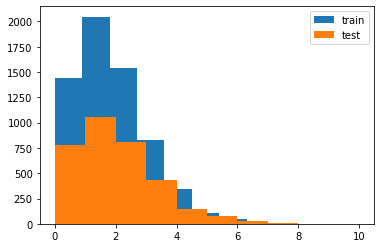

In [ ]:
# Проверим распределения таргета регрессии при помощи функции hist библиотеки matplotlib
import matplotlib.pyplot as plt

plt.hist(y_reg_train, label='train')
plt.hist(y_reg_test, label='test')
plt.legend()

Все ли в порядке с распределением таргета?

### Дубликаты и константные признаки

In [ ]:
# Посчитаем число уникальных значений в каждом из столбцов X_train
# Выберем все, в которых только одно уникальное значение
# Могли они быть не константными?
print(X_train.columns[X_train.nunique() == 1])

Index(['IS_HOME_x', 'IS_HOME_y'], dtype='object')


In [ ]:
# Удалим константные колонки из обучения и теста
X_train.drop(columns=['IS_HOME_x', 'IS_HOME_y'], inplace=True)
X_test.drop(columns=['IS_HOME_x', 'IS_HOME_y'], inplace=True)

In [ ]:
# Посмотрим появились ли у нас дубликаты при помофи метода .duplicated
print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

0
0


### Корреляция признаков

<AxesSubplot:>

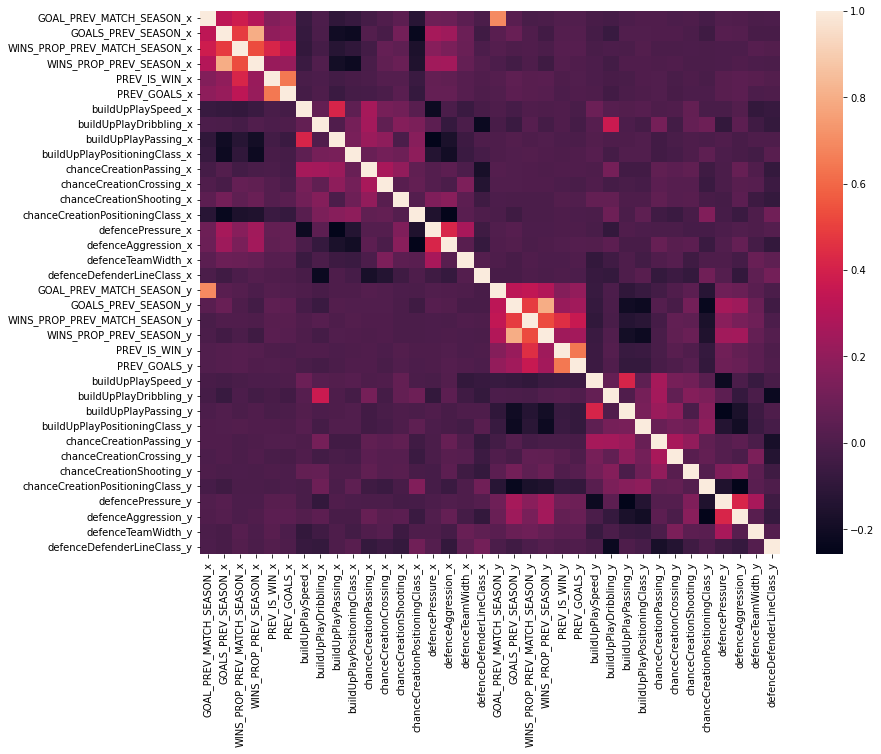

In [ ]:
# Построим матрицу корреляции признаков воспользовавшись библиотекой seaborn и методом corr()
import seaborn as sns
plt.figure(figsize=(13,10))

sns.heatmap(X_train.corr(), xticklabels=X_train.columns, yticklabels=X_train.columns)

Есть ли достаточно скоррелированные?

In [ ]:
# Удалите колонки, которые считаете слишком скоррелированными
...

### Построение данных в двухмерном пространстве

#### PCA

Мы можем воспользоваться PCA с числом копонент, равным 2, чтобы отрисовать точки на плоскости. В качестве цвета возьмем таргеты.

In [ ]:
# PCA из sklearn не умеет работать с пропусками, а в этот раз мы бы не хотели заполнять пропуски (дальше расскажем почему)
# Поскольку все поля у нас имеют положительные значения, давайте заменим пропуски на среднее значение по столбцу (fillna)
# Сделаем при этом глубокую копию, чтобы точно ничего не поменять в исходном датасете

X_train_pca = deepcopy(X_train.fillna(X_train.mean()))

In [ ]:
from sklearn.decomposition import PCA

# Создадим объект класса PCA с числом компонент, равным 2
pca = PCA(n_components=2)

# Сделаем fit_transform на X_train_pca
X_train_pca = pca.fit_transform(X_train_pca)

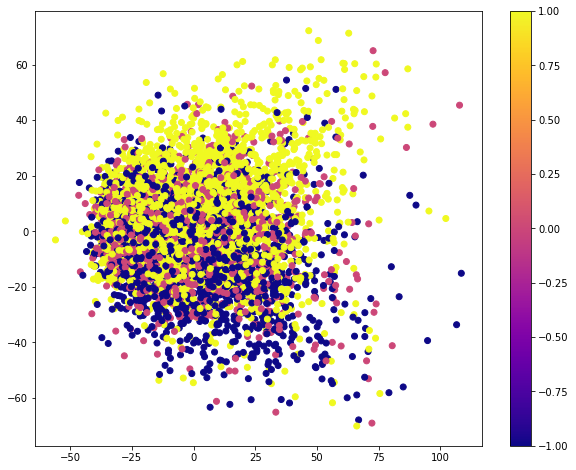

In [ ]:
# В качестве цвета возьмем классы. Какие выводы можно сделать?
plt.figure(figsize=(10,8))

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_class_train, cmap='plasma')

plt.colorbar()
plt.show()

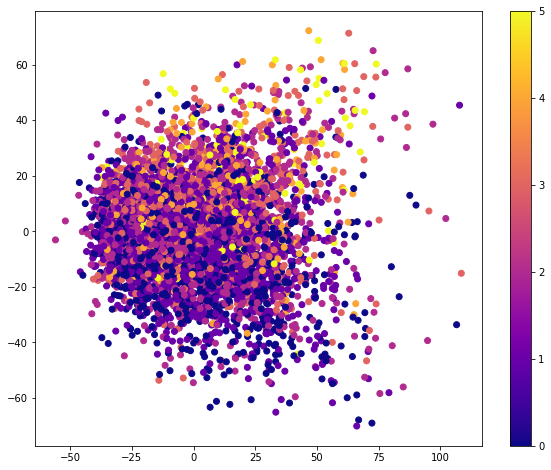

In [ ]:
# В качестве цвета возьмем таргет регрессии. Какие выводы можно сделать?
plt.figure(figsize=(10,8))

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_reg_train, cmap='plasma', vmin=0, vmax=5)

plt.colorbar()
plt.show()

#### [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

Это очень продвинутый алгоритм уменьшения размерности, который пытается приблизить распределение стьюдента одной размерности, распределением стьюдента более низкой размерности, минимально потеряв информации.

Этот алгоритм мог бы стать темой отдельного семинара, но сейчас мы его применим, что называется, "из коробки", чтобы посмотреть на наши данные в двухмерном пространстве.

In [ ]:
# Нам точно также нужно заполнить пропуски по той же причине
X_train_tsne = deepcopy(X_train.fillna(X_train.mean()))

In [ ]:
# Импортируем метод из sklearn 
from sklearn.manifold import TSNE

# Создадим объект класса tSNE c числом компонент, равным 2
tsne = TSNE(n_components=2)

In [ ]:
# Применим fit_transform метод
# Этот метод существенно медленнее PCA
X_train_tsne = tsne.fit_transform(X_train_tsne)

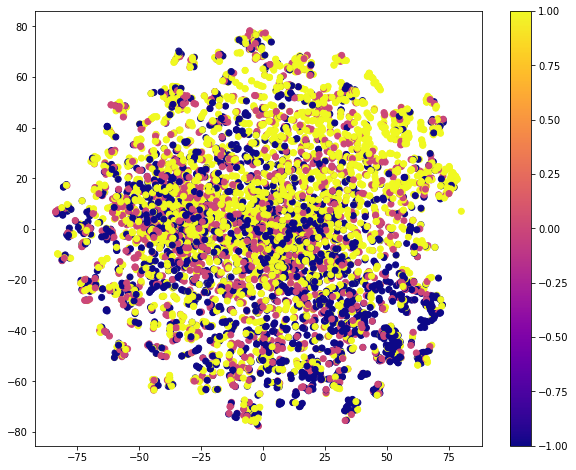

In [ ]:
# В качестве цвета возьмем классы. Какие выводы можно сделать?
plt.figure(figsize=(10,8))

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_class_train, cmap='plasma')

plt.colorbar()
plt.show()

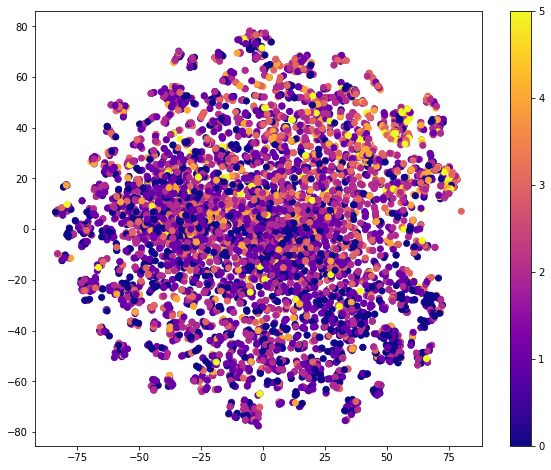

In [ ]:
# В качестве цвета возьмем таргет регрессии. Какие выводы можно сделать?
plt.figure(figsize=(10,8))

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_reg_train, cmap='plasma', vmin=0, vmax=5)

plt.colorbar()
plt.show()

В целом можно сказать, что в обоих случаях отслеживается зависимость, хоть в PCA более явно.

### Заполнение пропусков

Ранее мы сказали, что не хотим заполнять пропуски, но почему? Как наши модели должны понимать, что стоит на месте пропуска.

На самом деле мы немного схитрим -- мы будем использовать бустинг из библиотеки LightGBM. В этой библиотеки (как и в ряде других) есть алгоритм обработки пропусков. Однако этот алгоритм пригоден только для деревянных моделей.

Суть алгоритма -- если в какой-то момент нам нужно распределить объект в обучении, то мы отложим этот объект до конца построения дерева, а потом распределим его в такой лист, в котором он бы уменьшил ошибку алгоритма. Во время тестирования будем распределять объект с пропуском таким же путем, каким распределяли объекты во время обучения.

Этот алгорим требует дополнительные затраты на вычисления и память, но зато позволяет нам использовать пропуск как специальный символ.

### Ваши предложения для первичного анализа

Давайте проверим ваши гипотезы!

In [ ]:
...

Ellipsis

## Обучение baseline модели

### Выбор метрик

In [ ]:
# Какие бы метрики мы бы хотели смотреть на задаче классификации?

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report

# Какие бы метрики мы бы хотели смотреть на задаче регрессии?

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, max_error

### Создание модели

In [ ]:
from numpy.ma.core import log
# Для обоих задач будем использовать бустинг из библиотеки lightGBM
import lightgbm as lgb

# Создадим объекты классификации и регрессии с параметрами по умолчанию
model_cls = lgb.LGBMClassifier()
model_reg = lgb.LGBMRegressor()

In [ ]:
# Обучим модели на обучающем датасете

model_cls.fit(X_train, y_class_train)
model_reg.fit(X_train, y_reg_train)

LGBMRegressor()

In [ ]:
# Посмотрим на метрики классификации
# Не забываем, что у нас мультикласс. Давайте посмотрим на метрики при стратегии один против всех (average=None)

print("TRAIN")
y_pred = model_cls.predict(X_train)
y_pred_proba = model_cls.predict_proba(X_train)
print(f"classification report:\n  {classification_report(y_class_train, y_pred)}")
print(f"roc-auc: {roc_auc_score(y_class_train, y_pred_proba, multi_class='ovr')}")
print("TEST")
y_pred = model_cls.predict(X_test)
y_pred_proba = model_cls.predict_proba(X_test)
print(f"classification report:\n  {classification_report(y_class_test, y_pred)}")
print(f"roc-auc: {roc_auc_score(y_class_test, y_pred_proba, multi_class='ovr')}")

TRAIN
classification report:
                precision    recall  f1-score   support

          -1       0.86      0.77      0.81      1873
           0       0.96      0.64      0.77      1586
           1       0.76      0.95      0.85      2898

    accuracy                           0.82      6357
   macro avg       0.86      0.79      0.81      6357
weighted avg       0.84      0.82      0.82      6357

roc-auc: 0.9612435356228265
TEST
classification report:
                precision    recall  f1-score   support

          -1       0.46      0.41      0.44      1012
           0       0.30      0.09      0.13       855
           1       0.51      0.76      0.61      1459

    accuracy                           0.48      3326
   macro avg       0.42      0.42      0.39      3326
weighted avg       0.44      0.48      0.44      3326

roc-auc: 0.6207264186680804


Что можно заметить?

In [ ]:
# Посмотрим на важность признаков (feature_importances_) в модели классификации и проанализируем топ признаки
for feature, mdi in sorted(zip(X_train.columns, model_cls.feature_importances_), key=lambda x: -x[1]):
  print(f'{feature}: {mdi}')

WINS_PROP_PREV_MATCH_SEASON_x: 588
WINS_PROP_PREV_MATCH_SEASON_y: 551
GOAL_PREV_MATCH_SEASON_x: 473
GOALS_PREV_SEASON_y: 453
GOAL_PREV_MATCH_SEASON_y: 425
GOALS_PREV_SEASON_x: 399
WINS_PROP_PREV_SEASON_x: 389
WINS_PROP_PREV_SEASON_y: 387
chanceCreationShooting_x: 340
chanceCreationCrossing_x: 331
buildUpPlayPassing_y: 321
chanceCreationCrossing_y: 298
defencePressure_x: 273
buildUpPlaySpeed_y: 268
chanceCreationShooting_y: 257
buildUpPlayPassing_x: 256
chanceCreationPassing_x: 251
chanceCreationPassing_y: 251
defenceAggression_y: 251
defenceAggression_x: 249
buildUpPlaySpeed_x: 246
buildUpPlayDribbling_x: 246
defenceTeamWidth_x: 243
defenceTeamWidth_y: 234
defencePressure_y: 228
buildUpPlayDribbling_y: 226
PREV_GOALS_y: 210
PREV_GOALS_x: 202
PREV_IS_WIN_x: 49
PREV_IS_WIN_y: 42
chanceCreationPositioningClass_x: 25
chanceCreationPositioningClass_y: 23
buildUpPlayPositioningClass_y: 9
defenceDefenderLineClass_x: 4
defenceDefenderLineClass_y: 2
buildUpPlayPositioningClass_x: 0


In [ ]:
# Посмотрим на метрики регрессии
# Из-за того, что у нас могут быть значения равные 0, mape может вести себя не адекватно. Можно попробовать избежать этого прибавив константу

print("TRAIN")
y_pred = model_reg.predict(X_train)
print(f"MSE:       {mean_squared_error(y_reg_train, y_pred)}")
print(f"MAPE:      {mean_absolute_percentage_error(y_reg_train + 1, y_pred + 1)}")
print(f"max_error: {max_error(y_reg_train, y_pred)}")
print("TEST")
y_pred = model_reg.predict(X_test)
print(f"MSE:       {mean_squared_error(y_reg_test, y_pred)}")
print(f"MAPE:      {mean_absolute_percentage_error(y_reg_test + 1, y_pred + 1)}")
print(f"max_error: {max_error(y_reg_test, y_pred)}")

TRAIN
MSE:       0.8237090465717859
MAPE:      0.38275023399918023
max_error: 3.9116444985514374
TEST
MSE:       1.573129075631022
MAPE:      0.5293388375367711
max_error: 6.161634859758019


In [ ]:
# Посмотрим на важность признаков (feature_importances_) в модели классификации и проанализируем топ признаки
for feature, mdi in sorted(zip(X_train.columns, model_reg.feature_importances_), key=lambda x: -x[1]):
  print(f'{feature}: {mdi}')

WINS_PROP_PREV_MATCH_SEASON_y: 203
GOAL_PREV_MATCH_SEASON_x: 171
WINS_PROP_PREV_MATCH_SEASON_x: 171
GOAL_PREV_MATCH_SEASON_y: 148
GOALS_PREV_SEASON_x: 147
WINS_PROP_PREV_SEASON_y: 139
GOALS_PREV_SEASON_y: 129
WINS_PROP_PREV_SEASON_x: 121
chanceCreationCrossing_y: 118
chanceCreationPassing_x: 106
defencePressure_y: 105
defenceAggression_y: 98
defencePressure_x: 94
buildUpPlaySpeed_x: 92
chanceCreationShooting_x: 89
buildUpPlaySpeed_y: 89
buildUpPlayDribbling_x: 88
defenceTeamWidth_y: 87
buildUpPlayDribbling_y: 85
defenceAggression_x: 84
defenceTeamWidth_x: 84
buildUpPlayPassing_x: 82
chanceCreationCrossing_x: 81
chanceCreationShooting_y: 81
chanceCreationPassing_y: 79
buildUpPlayPassing_y: 75
PREV_GOALS_x: 53
PREV_GOALS_y: 51
PREV_IS_WIN_x: 15
chanceCreationPositioningClass_x: 13
chanceCreationPositioningClass_y: 12
PREV_IS_WIN_y: 7
buildUpPlayPositioningClass_y: 3
buildUpPlayPositioningClass_x: 0
defenceDefenderLineClass_x: 0
defenceDefenderLineClass_y: 0


### Избавимся от бесполезных признаков

In [ ]:
# Видим, что в обеих моделях есть признаки, которые имеют мизерный MDI (причем это одни и те же признаки)
# Поэтому давайте избавимся от них, удалив из датасета

X_train.drop(columns=['buildUpPlayPositioningClass_y', 'buildUpPlayPositioningClass_x', 'defenceDefenderLineClass_x', 'defenceDefenderLineClass_y'], inplace=True)
X_test.drop(columns=['buildUpPlayPositioningClass_y', 'buildUpPlayPositioningClass_x', 'defenceDefenderLineClass_x', 'defenceDefenderLineClass_y'], inplace=True)

Видим, что наши модели переобучаются, поэтому нам нужно настроить параметры.

## Подбор параметров и построение итоговой модели

In [ ]:
# Поспользуемся рандомизированным поиском параметров
# Импортируем GridSearchCV из модуля model_selection библиотеки sklearn
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [ ]:
%%time

# Задача классификации
grid_cls = RandomizedSearchCV(
            lgb.LGBMClassifier(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'lr': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'accuracy',    
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=30,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_cls.fit(X_train, y_class_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
CPU times: user 1.6 s, sys: 191 ms, total: 1.79 s
Wall time: 59.3 s


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(verbose=0), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'lr': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0....
       0.21241414, 0.21543434, 0.21845455, 0.22147475, 0.22449495,
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 7)},
                   return_train_score=True, scoring='accuracy', verbose=5)

In [ ]:
# Выведем набор лучших параметров (они хранятся в best_params_) и лучшую метрику

print(f"Лучшая метрика:   {grid_cls.best_score_}")
print(f"Лучшие параметры: {grid_cls.best_params_}")

Лучшая метрика:   0.5082586125530911
Лучшие параметры: {'max_depth': 2, 'lr': 0.2093939393939394}


In [ ]:
# Посмотрим на метрики классификации
# Не забываем, что у нас мультикласс. Давайте посмотрим на метрики при стратегии один против всех (average=None)

print("TRAIN")
y_pred = grid_cls.best_estimator_.predict(X_train)
print(classification_report(y_class_train, y_pred))
print("TEST")
y_pred = grid_cls.best_estimator_.predict(X_test)
print(classification_report(y_class_test, y_pred))

TRAIN
              precision    recall  f1-score   support

          -1       0.52      0.44      0.48      1873
           0       0.57      0.03      0.07      1586
           1       0.54      0.87      0.66      2898

    accuracy                           0.53      6357
   macro avg       0.54      0.45      0.40      6357
weighted avg       0.54      0.53      0.46      6357

TEST
              precision    recall  f1-score   support

          -1       0.49      0.40      0.44      1012
           0       0.36      0.01      0.03       855
           1       0.50      0.84      0.63      1459

    accuracy                           0.50      3326
   macro avg       0.45      0.42      0.37      3326
weighted avg       0.46      0.50      0.42      3326



А вот если бы даже на таких обрезанных данных смогли бы получить точность больше 50, то можно было озолотиться:))

In [ ]:
%%time

# Задача регрессии
grid_reg = RandomizedSearchCV(
            lgb.LGBMRegressor(verbose=0),          # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(2, 7),
                'lr': np.linspace(0.001, 0.3, 100),
            },
            scoring = 'neg_mean_absolute_error',    
            cv = 3,                                 # CV для кросс-валидации (число или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=30,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid_reg.fit(X_train, y_reg_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
CPU times: user 1.43 s, sys: 96.2 ms, total: 1.53 s
Wall time: 27 s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(verbose=0), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'lr': array([0.001     , 0.0040202 , 0.0070404 , 0.01006061, 0.01308081,
       0.01610101, 0.01912121, 0.02214141, 0.02516162, 0.02818182,
       0.03120202, 0.03422222, 0.03724242, 0.04026263, 0.04328283,
       0.04630303, 0.04932323, 0.05234343, 0.05536364, 0.05838384,
       0.06140404, 0.06442424, 0.0...
       0.22751515, 0.23053535, 0.23355556, 0.23657576, 0.23959596,
       0.24261616, 0.24563636, 0.24865657, 0.25167677, 0.25469697,
       0.25771717, 0.26073737, 0.26375758, 0.26677778, 0.26979798,
       0.27281818, 0.27583838, 0.27885859, 0.28187879, 0.28489899,
       0.28791919, 0.29093939, 0.2939596 , 0.2969798 , 0.3       ]),
                                        'max_depth': range(2, 7)},
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=5)

In [ ]:
# Выведем набор лучших параметров (они хранятся в best_params_) и лучшую метрику

print(f"Лучшая метрика:   {grid_reg.best_score_}")
print(f"Лучшие параметры: {grid_reg.best_params_}")

Лучшая метрика:   -0.9862053889909893
Лучшие параметры: {'max_depth': 2, 'lr': 0.14294949494949494}


In [ ]:
# Посмотрим на метрики регрессии
# Из-за того, что у нас могут быть значения равные 0, mape может вести себя не адекватно. Можно попробовать избежать этого прибавив константу

print("TRAIN")
y_pred = grid_reg.best_estimator_.predict(X_train)
print(f"MSE:       {mean_squared_error(y_reg_train, y_pred)}")
print(f"MAPE:      {mean_absolute_percentage_error(y_reg_train + 1, y_pred + 1)}")
print(f"max_error: {max_error(y_reg_train, y_pred)}")
print("TEST")
y_pred = grid_reg.best_estimator_.predict(X_test)
print(f"MSE:       {mean_squared_error(y_reg_test, y_pred)}")
print(f"MAPE:      {mean_absolute_percentage_error(y_reg_test + 1, y_pred + 1)}")
print(f"max_error: {max_error(y_reg_test, y_pred)}")

TRAIN
MSE:       1.4062512673934946
MAPE:      0.5009279478875504
max_error: 5.855964746784743
TEST
MSE:       1.5240469923259061
MAPE:      0.527447634405758
max_error: 6.677057642808739


In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
stacking_cls_model = StackingClassifier(
    estimators = [
        ('rf', RandomForestClassifier()),
        ('lgbm', grid_cls.best_estimator_),
        ('svm', SVC())
    ],
    final_estimator=LogisticRegression(penalty='l1', C=0.5, solver='liblinear')
)

In [ ]:
X_train_filled = X_train.fillna(X_train.median())
X_test_filled = X_test.fillna(X_train.median())

In [ ]:
stacking_cls_model.fit(X_train_filled, y_class_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier()),
                               ('lgbm',
                                LGBMClassifier(lr=0.2093939393939394,
                                               max_depth=2, verbose=0)),
                               ('svm', SVC())],
                   final_estimator=LogisticRegression(C=0.5, penalty='l1',
                                                      solver='liblinear'))

In [ ]:
print("TRAIN")
y_pred = stacking_cls_model.predict(X_train_filled)
print(classification_report(y_class_train, y_pred))
print("TEST")
y_pred = stacking_cls_model.predict(X_test_filled)
print(classification_report(y_class_test, y_pred))

TRAIN
              precision    recall  f1-score   support

          -1       0.36      0.38      0.37      1873
           0       0.00      0.00      0.00      1586
           1       0.60      0.92      0.73      2898

    accuracy                           0.53      6357
   macro avg       0.32      0.43      0.37      6357
weighted avg       0.38      0.53      0.44      6357

TEST
              precision    recall  f1-score   support

          -1       0.49      0.39      0.44      1012
           0       0.00      0.00      0.00       855
           1       0.49      0.85      0.62      1459

    accuracy                           0.49      3326
   macro avg       0.33      0.41      0.35      3326
weighted avg       0.37      0.49      0.41      3326



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Кажется подобрались не очень хорошие параметры. Поэксперементируем?

## Формирование отчета

In [ ]:
# Для задачи классификации воспользуемся функцией plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

ImportError: ignored

In [ ]:
# А также classification_report
from sklearn.metrics import classification_report

print(...)

Далее воспользуемся библиотекой shap, чтобы определить лучшие признаки и сделать выводы.

In [ ]:
# Установим библиотеку shap
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 12.6 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
# Создадим объект библиотеки shap -- explainer при помощи функции TreeExplainer библиотеки shap, который принимает модели классификации и регрессии
explainer_cls = shap.TreeExplainer(grid_cls.best_estimator_)
explainer_reg = shap.TreeExplainer(grid_reg.best_estimator_)

In [ ]:
# Посчитаем shap-values вызвав у explainer метод shap_values, передав в качестве аргумента датасет X_train
# для классификации и для регрессии

shap_values_cls = explainer_cls.shap_values(X_train)
shap_values_reg = explainer_reg.shap_values(X_train)

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


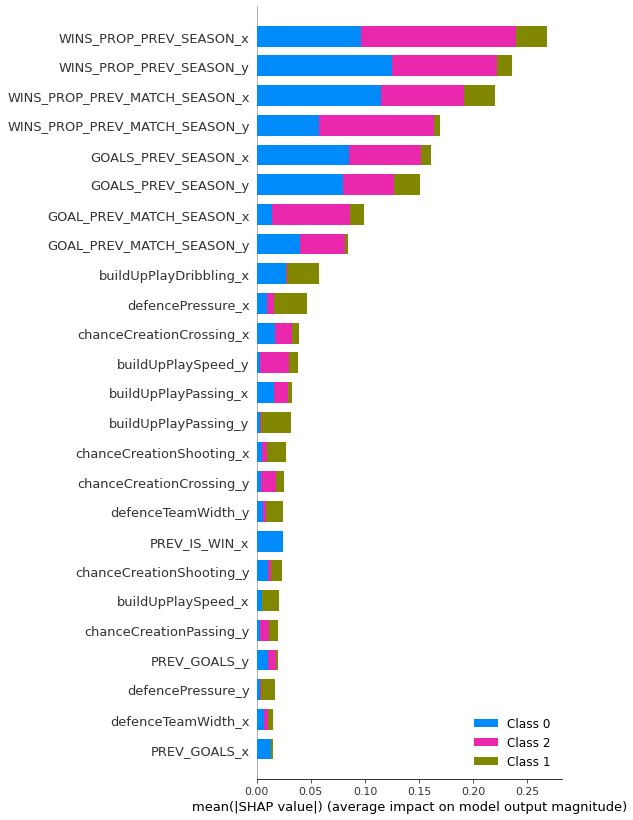

In [ ]:
# Посторим график важности фичей, вызвав summary_plot из библиотеки shap для классификации
shap.summary_plot(shap_values_cls, X_train, max_display=25, plot_size=(10, 10))

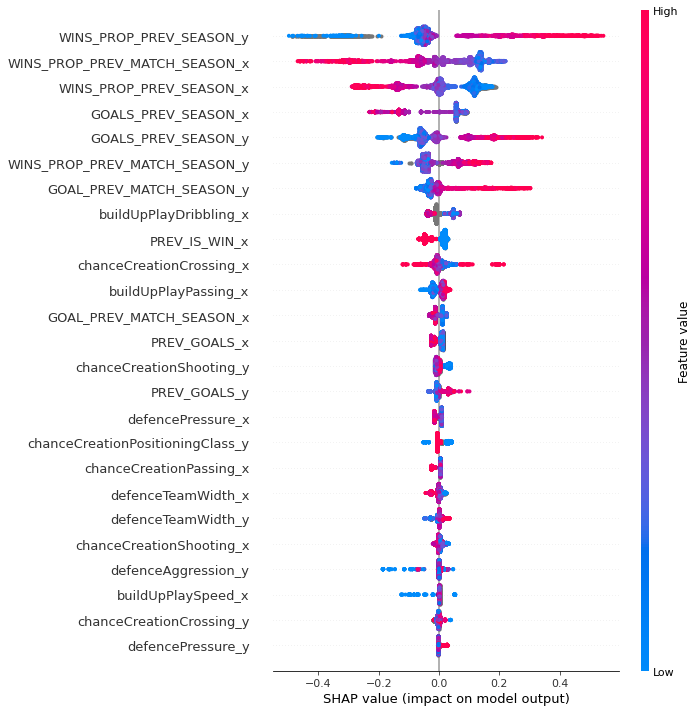

In [ ]:
# Если возьмем нулевой элемент у shap_values, то сможем посмотреть на более интересный график
shap.summary_plot(shap_values_cls[0], X_train, max_display=25, plot_size=(10, 10))

Сделайте выводы

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


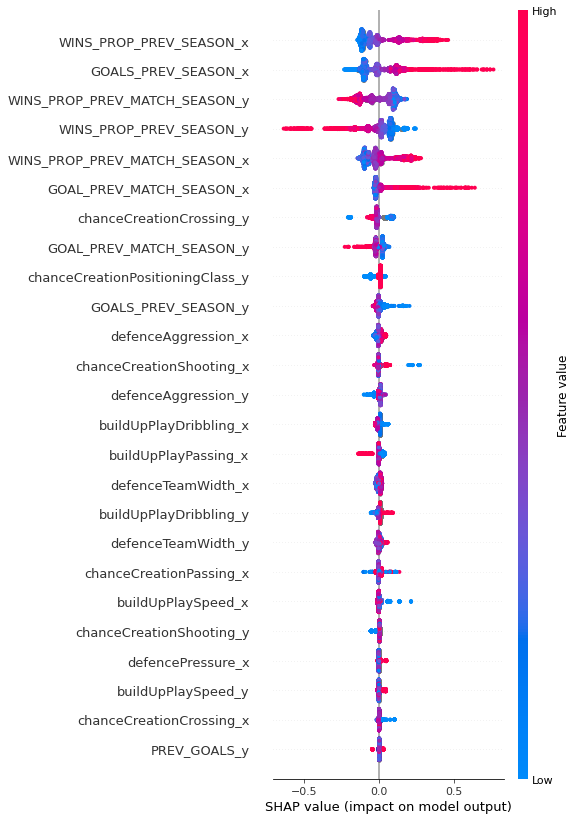

In [ ]:
# Посторим график важности фичей, вызвав summary_plot из библиотеки shap для регрессии
shap.summary_plot(shap_values_reg, X_train, max_display=25, plot_size=(10, 10))

In [ ]:
# Если возьмем нулевой элемент у shap_values, то сможем посмотреть на более интересный график
...

KeyError: ignored

Сделайте выводы

Если у вас остались силы, то мы можем продолжить улучшать нашу модель) 

Например подбором параметров, использованием PCA или какими-либо еще)

---

## Вывод

Мы с вами поняли, что задача предсказания выигрыша в футбольном матче -- это непростая задача -- для ее решения мы смогли построить только первичную модель, которую точно есть куда улучшать.

Вы можете придумать под тысячу валидных признаков (а если бы у вас была информация об игроках в командах, то даже еще больше) и потом вам придется придумать как их уменьшить, потому что в истории было не столько футбольных матчей, чтобы их было достаточно для обучения модели на хотя бы на 2 сотнях признаков.

В целом дальнейшее исследование этой задачи, может быть отличным выпускным проектом!